In [5]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib as mpl
import random
from datetime import timedelta
from numba import njit
#import glob
from scipy.interpolate import interp1d


import warnings
warnings.filterwarnings('ignore')

In [6]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
 

In [7]:
# download surveillance data

incidence = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())
observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


In [4]:
observations

,location,date,value
0,01,2023-09-09,5
1,45,2023-09-09,22
2,16,2023-09-09,2
3,46,2023-09-09,3
4,15,2023-09-09,5
...,...,...,...
1797,72,2024-04-27,44
1798,35,2024-04-27,20
1799,19,2024-04-27,22
1800,55,2024-04-27,38


In [5]:
obs = observations[observations.location=='US']

In [8]:
class QuantileBaseline:
    def __init__(self, inc_diffs, symmetrize=True):
        self.inc_diffs = inc_diffs
        self.symmetrize = symmetrize
      
    
def fit_quantile_baseline(incidence,target, symmetrize=True, window_size=None):
    if window_size is None:
        window_size = len(incidence) - 1
    if window_size >= len(incidence):
        window_size = len(incidence) - 1

    diffs = np.diff(incidence['value'])[-window_size:]
    diffs = diffs[~np.isnan(diffs)]
    
    if symmetrize:
        inc_diffs = list(diffs) + [-x for x in diffs]
    else:
        inc_diffs = list(diffs)

    return QuantileBaseline(inc_diffs=np.array(inc_diffs), symmetrize=symmetrize)



In [10]:
# generate baseline model

quantiles = [0.01, 0.025] + list(np.arange(0.05, 0.96, 0.05)) + [0.975, 0.99]
horizon = 4
num_samples = 100000

symmetrize=True
incidence = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


target = 'inc hosp'
# Generate forecast week end dates
forecast_week_end_dates = [num for num in observations['date'].unique() if num >= pd.to_datetime('2023-09-01')]

results_list = []

baseline_model = pd.DataFrame()
for forecast_week_end_date in forecast_week_end_dates:
    data = observations.copy()
    
    if len(data)==0:
        continue
    
    unique_locations = data['location'].unique()
    
    for location in unique_locations:
    
        location_data = data[data['location'] == location]
        
        location_data = location_data[location_data['date'] <= forecast_week_end_date]
        
        baseline_fit = fit_quantile_baseline(incidence=location_data,target=target, symmetrize=True, 
                                             window_size=None)


        ########### Predict function #############
        inc_data = location_data['value']

        last_observed_value = inc_data.iloc[-1]
        
        # Compute quantiles
        
        sampled_inc_diffs = np.quantile(baseline_fit.inc_diffs, np.linspace(0, 1, num_samples))

        # Ensure the median difference is 0
        median_diff = np.median(sampled_inc_diffs)
        sampled_inc_diffs -= median_diff

        # Compute the raw sampled incidence values
        sampled_inc_raw = last_observed_value + sampled_inc_diffs

        # Enforce non-negative incidence
        sampled_inc_raw = np.maximum(sampled_inc_raw, 0)
        predictions = np.quantile(sampled_inc_raw, quantiles, axis=0)
        
        #save first horizon
        results = pd.DataFrame({'horizon':1, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                'target_end_date': pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1)  ,
                                'target':'inc hosp','location':location ,'quantile':quantiles, 'value':predictions})
        
        baseline_model = pd.concat([baseline_model, results])
        
        for h in list(range(2, horizon+1)):
            
            # Sample differences again for new horizon
            sampled_inc_diffs = np.random.choice(sampled_inc_diffs, size=num_samples, replace=True)
            sampled_inc_raw = sampled_inc_raw + sampled_inc_diffs

            # Adjust incidence if symmetrize is TRUE
            if symmetrize:
                sampled_inc_corrected = sampled_inc_raw - (np.median(sampled_inc_raw) - last_observed_value)
            else:
                sampled_inc_corrected = sampled_inc_raw

            # Ensure non-negative incidence
            sampled_inc_corrected = np.maximum(sampled_inc_corrected, 0)

            
            
            predictionshorizon = np.quantile(sampled_inc_corrected, quantiles, axis=0)
        
            resultshorizon = pd.DataFrame({'horizon':h, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                           'target_end_date':pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1*h),
                                           'target':'inc hosp','location':location , 'quantile':quantiles, 
                                    'value':predictionshorizon})
        
            baseline_model = pd.concat([baseline_model, resultshorizon])
        
        
        
baseline_model['quantile'] = baseline_model['quantile'].round(2)         
        
        
        


In [398]:
baseline_model.to_pickle('../fludat/baseline_model_flu23-24.pkl')

In [399]:
baseline_model

,horizon,forecast_date,target_end_date,target,location,quantile,value
0,1,2023-09-02,2023-09-09,inc hosp,01,0.01,0.000000
1,1,2023-09-02,2023-09-09,inc hosp,01,0.02,0.000000
2,1,2023-09-02,2023-09-09,inc hosp,01,0.05,0.000000
3,1,2023-09-02,2023-09-09,inc hosp,01,0.10,0.000000
4,1,2023-09-02,2023-09-09,inc hosp,01,0.15,0.000000
...,...,...,...,...,...,...,...
18,4,2024-04-27,2024-05-25,inc hosp,34,0.85,220.431833
19,4,2024-04-27,2024-05-25,inc hosp,34,0.90,257.708100
20,4,2024-04-27,2024-05-25,inc hosp,34,0.95,318.730897
21,4,2024-04-27,2024-05-25,inc hosp,34,0.98,381.879435


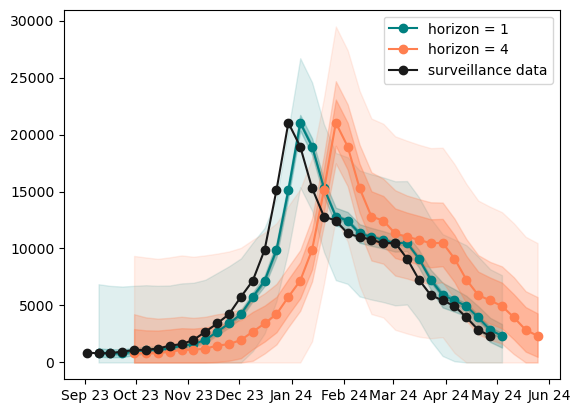

In [15]:
# plot 1 and 4-week-ahead baseline model forecasts for the 2023-24 flu season

quants = [(0.02,0.98),(.15, .85),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

fig, ax = plt.subplots(1,1)

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


#horizon = 1
colors = ['teal', 'coral']
location='US'
i=0
for horizon in [1,4]:
    for q in quants:
        
        alpha = map_alpha(q[1] - q[0])
        df = baseline_model[ (baseline_model.horizon==horizon)&\
                          (baseline_model.location == location)]

        qupp = baseline_model[(baseline_model['quantile']==q[0]) & (baseline_model.horizon==horizon)&\
                          (baseline_model.location == location)].value
        qlow = baseline_model[(baseline_model['quantile']==q[1]) & (baseline_model.horizon==horizon) &\
                          (baseline_model.location == location)].value

        plt.fill_between(df.target_end_date.unique(),qupp,qlow, color=colors[i], alpha=alpha)

    qmed = baseline_model[(baseline_model['quantile']==0.5) & (baseline_model.horizon==horizon) &\
                          (baseline_model.location == location)].value

    plt.plot(df.target_end_date.unique(),qmed,'-o', color=colors[i], alpha=1, label='horizon = '+ str(horizon))
    
    i+=1

set_date_axis_fmt(ax)
    
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.location==location) & (observations.date>=pd.to_datetime('2023-09-01')) ]


plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')
   
plt.legend()

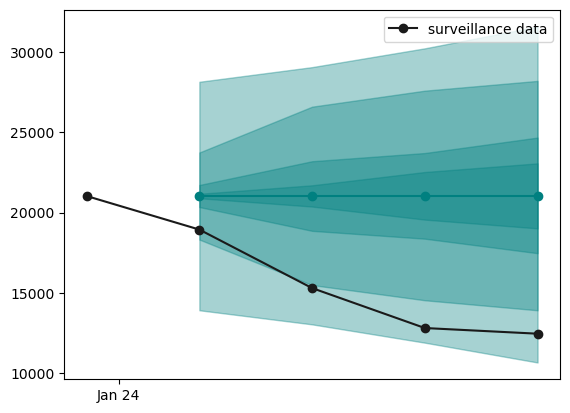

In [16]:
# 1-4 week ahead forecasts made at a given forecast date

quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

fig, ax = plt.subplots(1,1)

#horizon = 1
colors = ['teal', 'coral']
location='US'
i=0

for q in quants:
    df = baseline_model[ (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))&\
                      (baseline_model.location == location)]

    qupp = baseline_model[(baseline_model['quantile']==q[0]) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))&\
                      (baseline_model.location == location)].value
    qlow = baseline_model[(baseline_model['quantile']==q[1]) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30')) &\
                      (baseline_model.location == location)].value

    plt.fill_between(df.target_end_date.unique(),qupp,qlow, color=colors[i], alpha=alpha)

qmed = baseline_model[(baseline_model['quantile']==0.5) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30')) &\
                      (baseline_model.location == location)].value

plt.plot(df.target_end_date.unique(),qmed,'-o', color=colors[i], alpha=1)

i+=1

set_date_axis_fmt(ax)
    
observations = observations[(observations.location==location) ]
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.date>=pd.to_datetime('2023-12-30'))&\
                            (observations.date<=pd.to_datetime('2024-01-27'))]

plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')
   
plt.legend()

In [377]:
baseline_model

,horizon,forecast_date,target_end_date,target,location,quantile,value
0,1,2023-09-02,2023-09-09,inc hosp,US,0.01,0.000000
1,1,2023-09-02,2023-09-09,inc hosp,US,0.02,0.000000
2,1,2023-09-02,2023-09-09,inc hosp,US,0.05,0.000000
3,1,2023-09-02,2023-09-09,inc hosp,US,0.10,0.000000
4,1,2023-09-02,2023-09-09,inc hosp,US,0.15,506.350000
...,...,...,...,...,...,...,...
18,4,2024-04-27,2024-05-25,inc hosp,US,0.85,5842.382693
19,4,2024-04-27,2024-05-25,inc hosp,US,0.90,7326.029835
20,4,2024-04-27,2024-05-25,inc hosp,US,0.95,9214.748474
21,4,2024-04-27,2024-05-25,inc hosp,US,0.98,10556.870489


In [ ]:
# Generate trajectories from 4 week ahead baseline model

In [11]:
# generate trajectories by sampling from the distribution of historical differences

quantiles = [0.01, 0.025] + list(np.arange(0.05, 0.96, 0.05)) + [0.975, 0.99]
horizon = 4
num_samples = 100


incidence = True
symmetrize = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


target = 'inc hosp'
# Generate forecast week end dates
forecast_week_end_dates = [num for num in observations['date'].unique() if num >= pd.to_datetime('2023-09-01')]

results_list = []

baseline_model = pd.DataFrame()

for forecast_week_end_date in forecast_week_end_dates:
    data = observations.copy()
    
    if len(data)==0:
        continue
    
    unique_locations = data['location'].unique()
    
    for location in unique_locations:
    
        location_data = data[data['location'] == location]
        
        location_data = location_data[location_data['date'] <= forecast_week_end_date]
        
        baseline_fit = fit_quantile_baseline(incidence=location_data,target=target, symmetrize=True, 
                                             window_size=None)


        ########### Predict function #############
        inc_data = location_data['value']

        last_observed_value = inc_data.iloc[-1]
    
        # Compute quantiles
        
        sampled_inc_diffs = np.quantile(baseline_fit.inc_diffs, np.linspace(0, 1, num_samples))

        # Ensure the median difference is 0
        median_diff = np.median(sampled_inc_diffs)
        sampled_inc_diffs -= median_diff

        # Compute the raw sampled incidence values
        sampled_inc_raw = last_observed_value + sampled_inc_diffs

        # Enforce non-negative incidence
        sampled_inc_raw = np.maximum(sampled_inc_raw, 0)
 
        #save first horizon
        results = pd.DataFrame({'horizon':1, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                'target_end_date': pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1)  ,
                                'target':'inc hosp','location':location ,'trajectory_id':list(range(100)), 
                                'value':sampled_inc_raw})
        
        baseline_model = pd.concat([baseline_model, results])
        
        for h in list(range(2, horizon+1)):
            
            # Sample differences again for new horizon
            sampled_inc_diffs = np.random.choice(sampled_inc_diffs, size=num_samples, replace=True)
            sampled_inc_raw = sampled_inc_raw + sampled_inc_diffs

            # Adjust incidence if symmetrize is TRUE
            if symmetrize:
                sampled_inc_corrected = sampled_inc_raw - (np.median(sampled_inc_raw) - last_observed_value)
            else:
                sampled_inc_corrected = sampled_inc_raw

            # Ensure non-negative incidence
            sampled_inc_corrected = np.maximum(sampled_inc_corrected, 0)

            resultshorizon = pd.DataFrame({'horizon':h, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                           'target_end_date':pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1*h),
                                           'target':'inc hosp','location':location , 'trajectory_id':list(range(100)), 
                                    'value':sampled_inc_corrected})
        
            baseline_model = pd.concat([baseline_model, resultshorizon])
               


In [12]:
baseline_model.to_pickle('../fludat/flu-baseline_trajectories.pkl')

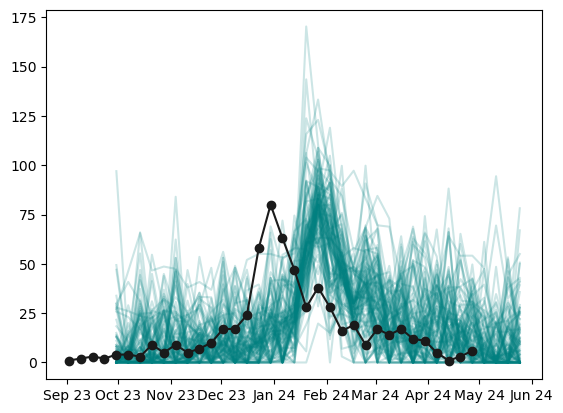

In [141]:
# plot baseline model trajectories

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

fig,ax = plt.subplots(1,1)

df = baseline_model[(baseline_model.location=='49') & (baseline_model.horizon==4)]
for i in df.trajectory_id.unique():
    plt.plot(df.target_end_date.unique(), df[df.trajectory_id==i].value, color='teal', alpha=.2)
    
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.location=='49') & (observations.date>=pd.to_datetime('2023-09-01')) ]


plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')

set_date_axis_fmt(ax)

In [219]:
# calculate energy score for flu baseline model from trajectories

from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES

baseline_model= pd.read_pickle('../fludat/flu-baseline_trajectories.pkl')
baselinedf = baseline_model[baseline_model.horizon==4]

energyscoresdf = pd.DataFrame()

for location in baselinedf.location.unique():
    
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    dffilt = baselinedf[(baselinedf.location==location) & (baselinedf.target_end_date>pd.to_datetime('2023-12-01'))&\
                       (baselinedf.target_end_date<pd.to_datetime('2024-02-01'))]
    
    
    if len(dffilt) == 0:
        print(f'no predictions  at location {loc} ')
        continue

    observations = observations[(observations['date'] >= dffilt.target_end_date.min()) & \
                                (observations['date'] <= dffilt.target_end_date.max())]   


    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    #filter location
    observations = observations[observations['location'] == location]

    dffilt = dffilt[dffilt.target_end_date <= observations.date.max()]

    y = np.array(observations.value)
    X = [np.array(dffilt[dffilt['trajectory_id'] == i].value) for i in dffilt['trajectory_id'].unique()]

    ES = energyscore(np.array(X),y)



    newrow = pd.DataFrame({'Model':'flu-baseline','location':location, 
                        'target':'inc hosp', 'horizon':4, 'energyscore':ES, }, index=[0])

    energyscoresdf = pd.concat([energyscoresdf, newrow])


energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   




In [92]:
baseline_model[baseline_model.horizon==4]

,horizon,forecast_date,target_end_date,target,location,trajectory_id,value
0,4,2023-09-02,2023-09-30,inc hosp,01,0,117.540404
1,4,2023-09-02,2023-09-30,inc hosp,01,1,0.000000
2,4,2023-09-02,2023-09-30,inc hosp,01,2,22.419192
3,4,2023-09-02,2023-09-30,inc hosp,01,3,11.267677
4,4,2023-09-02,2023-09-30,inc hosp,01,4,103.621212
...,...,...,...,...,...,...,...
95,4,2024-04-27,2024-05-25,inc hosp,34,95,263.272727
96,4,2024-04-27,2024-05-25,inc hosp,34,96,369.636364
97,4,2024-04-27,2024-05-25,inc hosp,34,97,336.727273
98,4,2024-04-27,2024-05-25,inc hosp,34,98,329.363636


In [220]:
energyscoresdf.to_pickle('../fludat/flu-baseline_energyscore_1025b.pkl')

In [25]:
# calculate energy score for flu baseline model for multiple dimensions

from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

baselinedf = baseline_model[baseline_model.horizon==4]

#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>pd.to_datetime('2023-11-18'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66')]


obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

energyscores_locations = pd.DataFrame()
for it in range(100):
    
    loc_array ={}
    j=0
    for loc in locations:
        if loc in ['72', '66']:
            continue
        predictionshosp = baselinedf[(baselinedf.target_end_date <= hosp.date.max()) & \
                                    (baselinedf.target_end_date >= hosp.date.min())&\
                                    (baselinedf.location==loc)]

        newid = random.sample(list(predictionshosp['trajectory_id']), 
                              k=len(list(predictionshosp['trajectory_id'])))
        predictionshosp['new_id'] = newid

        Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                 i in predictionshosp.new_id.unique()])

        loc_array[loc] = Xhosp

        j+=1

    A = []
    for i in range(len(Xhosp)):
        B = []
        for loc in locations:
            if loc in ['72', '66']:
                continue
            B.append(loc_array[loc][i])
        B = np.array(B)
        A.append(B)

    A = np.array(A)



    ES = energyscore_multipletargets(A,obs)


    newrow = pd.DataFrame({'Model':'flu-baseline' , 'location':'all',  
                         'energyscore': ES, 'it':it}, index=[0])

    energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  


In [27]:
energyscores_locations.to_pickle('../fludat/flu-baseline_energyscore_multidim.pkl')

In [32]:
energyscores_locations.max()

Model          flu-baseline
location                all
energyscore       34.403481
it                       99
dtype: object

<Axes: xlabel='energyscore'>

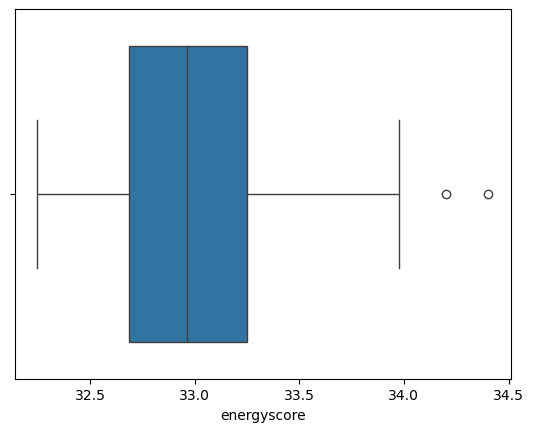

In [29]:
sns.boxplot(x='energyscore', data=energyscores_locations)

In [35]:
from numba import njit
@njit
def energyscore_terms_norm(X,y):
    # X is matrix of trajectories, y is observations
    ES1 = 0
    ES2 = 0
    N = X.shape[0]
    for i in range(N):
        ES1+=np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES2 -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES1, ES2


In [36]:
baselinedf = baseline_model[baseline_model.horizon==4]

#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>pd.to_datetime('2023-11-18'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66')]


obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

energyscores_locations = pd.DataFrame()
for it in range(100):
    
    loc_array ={}
    j=0
    for loc in locations:
        if loc in ['72', '66']:
            continue
        predictionshosp = baselinedf[(baselinedf.target_end_date <= hosp.date.max()) & \
                                    (baselinedf.target_end_date >= hosp.date.min())&\
                                    (baselinedf.location==loc)]

        newid = random.sample(list(predictionshosp['trajectory_id']), 
                              k=len(list(predictionshosp['trajectory_id'])))
        predictionshosp['new_id'] = newid

        Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                 i in predictionshosp.new_id.unique()])

        loc_array[loc] = Xhosp

        j+=1

    A = []
    for i in range(len(Xhosp)):
        B = []
        for loc in locations:
            if loc in ['72', '66']:
                continue
            B.append(loc_array[loc][i])
        B = np.array(B)
        A.append(B)

    A = np.array(A)



    ES1,ES2 = energyscore_terms_norm(A,obs)


    newrow = pd.DataFrame({'Model':'flu-baseline' , 'location':'all',  
                         'term1': ES1,'term2':ES2, 'it':it}, index=[0])

    energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  


In [37]:
energyscores_locations

,Model,location,term1,term2,it
0,flu-baseline,all,74.145585,-40.210957,0
1,flu-baseline,all,74.314847,-40.432909,1
2,flu-baseline,all,70.923280,-38.784272,2
3,flu-baseline,all,71.668241,-39.008081,3
4,flu-baseline,all,73.585331,-40.559236,4
...,...,...,...,...,...
95,flu-baseline,all,74.005080,-40.464726,95
96,flu-baseline,all,73.275197,-40.336581,96
97,flu-baseline,all,72.924755,-39.849488,97
98,flu-baseline,all,73.088131,-39.886776,98


Text(0, 0.5, 'Second term- Sharpness')

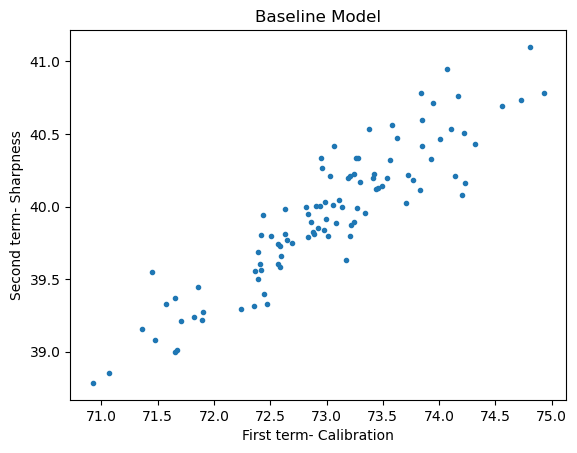

In [42]:
plt.plot(energyscores_locations.term1, [-i for i in energyscores_locations.term2], '.')

plt.title('Baseline Model')
plt.xlabel('First term- Calibration')
plt.ylabel('Second term- Sharpness')

In [221]:
# look at multitarget leaving bad states out

# calculate energy score for flu baseline model from trajectories

@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

baseline_model= pd.read_pickle('../fludat/flu-baseline_trajectories.pkl')
baselinedf = baseline_model[baseline_model.horizon==4]

energyscoresdf = pd.DataFrame()

for location in baselinedf.location.unique():
    
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    dffilt = baselinedf[(baselinedf.location==location) & (baselinedf.target_end_date>pd.to_datetime('2023-12-01'))&\
                       (baselinedf.target_end_date<pd.to_datetime('2024-02-01'))]
    
    
    if len(dffilt) == 0:
        print(f'no predictions  at location {loc} ')
        continue

    observations = observations[(observations['date'] >= dffilt.target_end_date.min()) & \
                                (observations['date'] <= dffilt.target_end_date.max())]   


    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    #filter location
    observations = observations[observations['location'] == location]

    dffilt = dffilt[dffilt.target_end_date <= observations.date.max()]

    y = np.array(observations.value)
    X = [np.array(dffilt[dffilt['trajectory_id'] == i].value) for i in dffilt['trajectory_id'].unique()]

    ES = normalized_energyscore(np.array(X),y)



    newrow = pd.DataFrame({'Model':'flu-baseline','location':location, 
                        'target':'inc hosp', 'horizon':4, 'energyscore':ES, }, index=[0])

    energyscoresdf = pd.concat([energyscoresdf, newrow])


energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   




In [222]:
energyscoresdf.to_pickle('../fludat/flu-baseline_energyscore_norm_1025b.pkl')

In [105]:
energyscoresdf=pd.read_pickle('../fludat/flu-baseline_energyscore_norm.pkl')

,Model,location,target,horizon,energyscore
0,flu-baseline,01,inc hosp,4,4.618578
1,flu-baseline,53,inc hosp,4,10.443149
2,flu-baseline,23,inc hosp,4,NaN
3,flu-baseline,21,inc hosp,4,5.584594
4,flu-baseline,30,inc hosp,4,NaN
5,flu-baseline,38,inc hosp,4,NaN
6,flu-baseline,22,inc hosp,4,3.697724
7,flu-baseline,39,inc hosp,4,5.000613
8,flu-baseline,11,inc hosp,4,NaN
9,flu-baseline,50,inc hosp,4,NaN


In [77]:
# calculate energy score for flu baseline model for multiple dimensions

from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

baselinedf = baseline_model[baseline_model.horizon==4]

#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>pd.to_datetime('2023-11-18'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66') & (hosp.location!='49')]


obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

energyscores_locations = pd.DataFrame()
for it in range(100):
    
    loc_array ={}
    j=0
    for loc in locations:
        if loc in ['72', '66']:
            continue
        predictionshosp = baselinedf[(baselinedf.target_end_date <= hosp.date.max()) & \
                                    (baselinedf.target_end_date >= hosp.date.min())&\
                                    (baselinedf.location==loc)]

        newid = random.sample(list(predictionshosp['trajectory_id']), 
                              k=len(list(predictionshosp['trajectory_id'])))
        predictionshosp['new_id'] = newid

        Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                 i in predictionshosp.new_id.unique()])

        loc_array[loc] = Xhosp

        j+=1

    A = []
    for i in range(len(Xhosp)):
        B = []
        for loc in locations:
            if loc in ['72', '66']:
                continue
            B.append(loc_array[loc][i])
        B = np.array(B)
        A.append(B)

    A = np.array(A)



    ES = energyscore_multipletargets(A,obs)


    newrow = pd.DataFrame({'Model':'flu-baseline' , 'location':'all',  
                         'energyscore': ES, 'it':it}, index=[0])

    energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locationsworst = energyscores_locations.reset_index().drop(columns=['index'])  


In [78]:
energyscores_locationsworst['Model'] = 'remove worst performing location'

In [79]:
energyscores_locationsall = pd.read_pickle('../fludat/flu-baseline_energyscore_multidim.pkl')
energyscores_locationsall['Model'] = 'all locations'

ES_locationsdf = pd.concat([energyscores_locationsworst, energyscores_locationsbest, energyscores_locationsall])

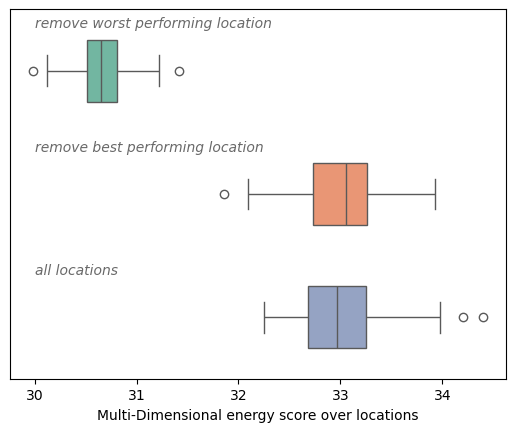

In [80]:
sns.boxplot(x='energyscore',y='Model', data=ES_locationsdf, hue='Model',palette='Set2', width=.5)
plt.yticks([])
plt.ylabel('')
plt.xlabel('Multi-Dimensional energy score over locations')

a = 0
for mod in ES_locationsdf.Model.unique():
    plt.text(30,a-.35, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

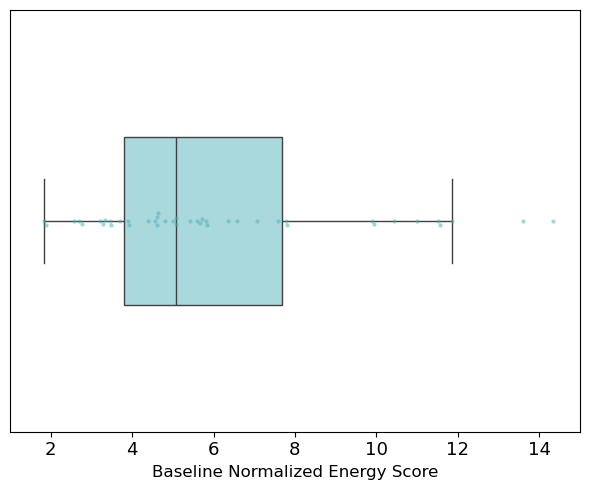

In [100]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
#plt.subplots_adjust(hspace=4)
i=1

#baseline = pd.read_pickle('../fludat/flu-baseline_energyscore.pkl').rename(columns={'energyscore':'energyscore_baseline',
#                                                                           'Model':'baseline_model'})

ESnorm = pd.read_pickle("../fludat/flu-baseline_energyscore_norm.pkl")
ESnorm['target'] = 'inc hosp'


rankinfo = ESnorm.copy()


#my_order = rankinfo.Label.unique()

g = sns.boxplot(x='energyscore',  data=rankinfo,color = '#17B1BF', width=0.4,
               showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .4))
    
# plot underlying distribution
sns.swarmplot(x='energyscore',  data=rankinfo,color = "#49AFB7",alpha = .5,size=3,
              orient="h")  

g.set(yticklabels=[])
g.set(yticks=[])

plt.ylabel('', fontsize=15)
plt.xlabel('Baseline Normalized Energy Score', fontsize=12)

i+=1 
#plt.title(scenario, fontsize=14)
plt.xlim([1, 15])



#plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)


a = 0
#for mod in list(my_order):
 #   plt.text(1.1,a-.25, mod, fontsize=10, style='italic', color='dimgray')
  #a+=1

plt.xticks(fontsize=13)
plt.tight_layout()

#plt.savefig('../figs/ESratio_MOBS_1017.pdf')
plt.show()

In [112]:
from numba import njit
@njit
def energyscore_terms(X,y):
    # X is matrix of trajectories, y is observations
    # get the contribution of each term to the full energy score 
    ES1 = 0
    ES2 = 0
    N = X.shape[0]
    for i in range(N):
        ES1+=np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES2 -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES1, ES2


Text(0, 0.5, 'Energy Score Components')

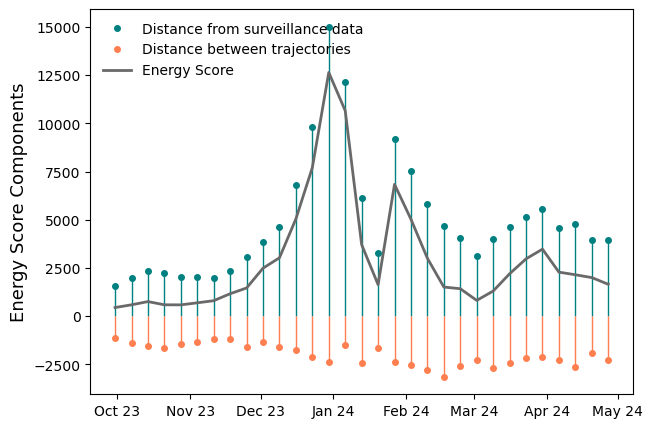

In [225]:
from numba import njit
@njit
def energyscore_terms(X,y):
    # X is matrix of trajectories, y is observations
    # get the contribution of each term to the full energy score 
    ES1 = 0
    ES2 = 0
    N = X.shape[0]
    for i in range(N):
        ES1+=np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES2 -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES1, ES2
location='US'
baseline_model= pd.read_pickle('../fludat/flu-baseline_trajectories.pkl')
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")


# calculate energy score for each week and plot
df = baseline_model[(baseline_model.location==location) & (baseline_model.horizon==4)]

observations['date'] = pd.to_datetime(observations['date'])

observations = observations[(observations['date'] >= df.target_end_date.min()) & \
                                        (observations['date'] <= max_date)]   


#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

#filter location
observations = observations[observations['location'] == location]

df = df[df.target_end_date <= observations.date.max()]

ESsum = []
ESsub = []
ESall = []
for date in observations.date.unique():
    obs = observations[observations.date==date]
    pdf = df[df.target_end_date==date]
    
    y = np.array(obs.value)
    X = [np.array(pdf[pdf['trajectory_id'] == i].value) for i in pdf['trajectory_id'].unique()]


    ES1, ES2 = energyscore_terms(np.array(X),y)

    ES = energyscore(np.array(X), y)
    
    ESsum.append(ES1)
    ESsub.append(ES2)
    ESall.append(ES)

dates = observations.date.unique()
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.subplot(1,1,1)
ax.vlines(dates, ymin=0, ymax=ESsum, color='teal', linewidth=1) 
  
# drawing the markers (circle) 
plt.plot(dates, ESsum, "o",markersize=4, color='teal', label='Distance from surveillance data') 

ax.vlines(dates, ymin=ESsub, ymax=0, color='coral', linewidth=1) 
plt.plot(dates, ESsub, "o",markersize=4, color='coral', label='Distance between trajectories') 
  
plt.plot(dates, ESall,linewidth=2, color='dimgray', label='Energy Score') 
set_date_axis_fmt(ax)
   
plt.legend(loc='upper left', frameon=False)
plt.ylabel('Energy Score Components', fontsize=13)



In [170]:
li = list(df[df.target_end_date==pd.to_datetime('2023-12-30')].value)

s = 0
for i in range(len(li)):
        for j in range(len(li)):
            s += np.sqrt(np.sum((li[i]-li[j])**2))/(2*len(li)**2)

In [171]:
s

5.297584848484877

Text(0, 0.5, 'Normalized Energy Score Components')

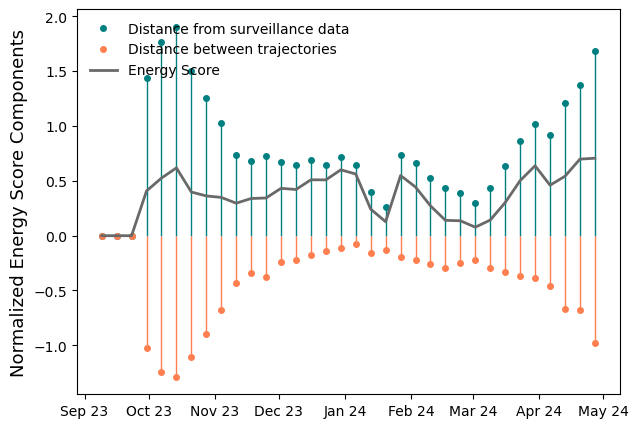

In [227]:
from numba import njit
@njit
def energyscore_terms(X,y):
    # X is matrix of trajectories, y is observations
    # get the contribution of each term to the full energy score 
    ES1 = 0
    ES2 = 0
    N = X.shape[0]
    for i in range(N):
        ES1+=np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES2 -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES1, ES2

location='US'

# calculate energy score for each week and plot
df = baseline_model[(baseline_model.location==location) & (baseline_model.horizon==4)]
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   


#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

#filter location
observations = observations[observations['location'] == location]

ESsum = []
ESsub = []
ESall = []
for date in observations.date.unique():
    obs = observations[observations.date==date]
    pdf = df[df.target_end_date==date]
    
    y = np.array(obs.value)
    X = [np.array(pdf[pdf['trajectory_id'] == i].value) for i in pdf['trajectory_id'].unique()]


    ES1, ES2 = energyscore_terms(np.array(X),y)

    ES = normalized_energyscore(np.array(X), y)
    
    ESsum.append(ES1)
    ESsub.append(ES2)
    ESall.append(ES)

dates = observations.date.unique()
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.subplot(1,1,1)
ax.vlines(dates, ymin=0, ymax=ESsum, color='teal', linewidth=1) 
  
# drawing the markers (circle) 
plt.plot(dates, ESsum, "o",markersize=4, color='teal', label='Distance from surveillance data') 

ax.vlines(dates, ymin=ESsub, ymax=0, color='coral', linewidth=1) 
plt.plot(dates, ESsub, "o",markersize=4, color='coral', label='Distance between trajectories') 
  
plt.plot(dates, ESall,linewidth=2, color='dimgray', label='Energy Score') 
set_date_axis_fmt(ax)
   
plt.legend(loc='upper left', frameon=False)
plt.ylabel('Normalized Energy Score Components', fontsize=13)



In [213]:
df.target_end_date.unique()

array(['2023-09-30T00:00:00.000000000', '2023-10-07T00:00:00.000000000',
       '2023-10-14T00:00:00.000000000', '2023-10-21T00:00:00.000000000',
       '2023-10-28T00:00:00.000000000', '2023-11-04T00:00:00.000000000',
       '2023-11-11T00:00:00.000000000', '2023-11-18T00:00:00.000000000',
       '2023-11-25T00:00:00.000000000', '2023-12-02T00:00:00.000000000',
       '2023-12-09T00:00:00.000000000', '2023-12-16T00:00:00.000000000',
       '2023-12-23T00:00:00.000000000', '2023-12-30T00:00:00.000000000',
       '2024-01-06T00:00:00.000000000', '2024-01-13T00:00:00.000000000',
       '2024-01-20T00:00:00.000000000', '2024-01-27T00:00:00.000000000',
       '2024-02-03T00:00:00.000000000', '2024-02-10T00:00:00.000000000',
       '2024-02-17T00:00:00.000000000', '2024-02-24T00:00:00.000000000',
       '2024-03-02T00:00:00.000000000', '2024-03-09T00:00:00.000000000',
       '2024-03-16T00:00:00.000000000', '2024-03-23T00:00:00.000000000',
       '2024-03-30T00:00:00.000000000', '2024-04-06

# Multitarget energy score

In [228]:
from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)**2)/np.sum(y,axis=1)[:, np.newaxis]))/ N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])**2)/np.sum(y,axis=1)[:, np.newaxis]))/(2*N**2)
    return ES


In [240]:

energyscores_locations = pd.DataFrame()

baselinedf = baseline_model[baseline_model.horizon==4]

#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>=pd.to_datetime('2023-09-30'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66') & (hosp.location!='49')]


obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

energyscores_locations = pd.DataFrame()
for it in range(100):
    
    dfall = pd.DataFrame()
    j=0
    for loc in locations:
        if loc in ['72', '66']:
            continue
        predictionshosp = baselinedf[(baselinedf.target_end_date <= hosp.date.max()) & \
                                    (baselinedf.target_end_date >= hosp.date.min())&\
                                    (baselinedf.location==loc)]
        newid = random.sample(list(predictionshosp['trajectory_id'].unique()), 
                              k=len(list(predictionshosp['trajectory_id'].unique())))
        predictionshosp['new_id'] = predictionshosp['trajectory_id'].apply(lambda key: newid[key-1])

        dfall = pd.concat([dfall,predictionshosp])

    tlist = []
    for tid in dfall.new_id.unique():
        dfilt = dfall[dfall.new_id==tid]
        llist = []
        for loc in dfilt.location.unique():
            d = dfilt[dfilt.location==loc].sort_values(by='target_end_date')
            llist.append(list(d.value))

        tlist.append(llist)


    A = np.array(tlist)

    #print(A)


    ES = energyscore_multipletargets(A,obs)


    newrow = pd.DataFrame({'Model':'baseline' , 'location':'US',  
                         'energyscore': ES, 'it':it}, index=[0])

    energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [241]:
energyscores_locations

,Model,location,energyscore,it
0,baseline,US,69.340682,0
1,baseline,US,69.328548,1
2,baseline,US,69.366312,2
3,baseline,US,69.329781,3
4,baseline,US,69.348457,4
...,...,...,...,...
95,baseline,US,69.355827,95
96,baseline,US,69.337376,96
97,baseline,US,69.336576,97
98,baseline,US,69.354776,98


In [243]:
energyscores_locations.to_csv('../fludat/multitarget_loc_baseline_115.csv')